# Анализ Maise данных

## Загрузка данных

### Анализируемые данные
- `T1` - данные с сервера T1, где размер буффера 8 мб
- `T3` - данные с сервера Т3, где стандартный размер буффера

Потоки `trade` и `level` для инструментов `BTCUSDT` и `1000PEPEUSDT` за 18.01.2025

In [136]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

# USE_COLS - используемые столбцы
# SECTION - секция на бирже
# SECURITIES - инструменты
# STREAMS - потоки данных
USE_COLS=["receive_ts"]
SECTION = "BINANCE_USDM"
SECURITIES = ["BTCUSDT", "1000PEPEUSDT"]
SERVERS = ["T1", "T3"]
STREAMS = ["trade", "level"]
DATA_DIR = Path("data")
# Получение путей к данным из /data/{SERVER}/{SECTION}/{SECURITY}/{STREAM}.csv

data_paths = {
    security: {
        stream: {
            server: DATA_DIR / server / SECTION / security / f"{stream}.csv"
            for server in SERVERS
        }
        for stream in STREAMS
    }
    for security in SECURITIES
}


На данном этапе мы загрузили данные с серверов T1 и T3, где размер буффера 8 мб и стандартный размер буффера соответственно. Данные представлены в виде потоков `trade` и `level` для инструментов `BTCUSDT` и `1000PEPEUSDT` за 18.01.2025.

Данные можно получить из переменной `data_paths`:
например, данные для инструмента `BTCUSDT` и потока `trade` с сервера T1:
```python
data_paths["BTCUSDT"]["trade"]["T1"]
```

In [137]:
# Загрузим данные в Pandas DataFrame для дальнейшего анализа

# data = {
#     security: {
#         stream: {
#             server: pd.read_csv(path, usecols=USE_COLS, delimiter=";")
#             for server, path in paths.items()
#         }
#         for stream, paths in paths.items()
#     }
#     for security, paths in data_paths.items()
# }

trade_data = {
    security: {
        server: pd.read_csv(data_paths[security]["trade"][server], usecols=USE_COLS, delimiter=";")
        for server in SERVERS
    }
    for security in SECURITIES
}


In [138]:
# Пример загруженных данных
trade_data["BTCUSDT"]["T1"].head()

,receive_ts
0,1737158405369050
1,1737158405375052
2,1737158405377660
3,1737158405383222
4,1737158405402041


In [139]:
# Рассчитаем receive_ts_diff для данных на серверах

for security in SECURITIES:
    for server in SERVERS:
        trade_data[security][server]["receive_ts_diff"] = (trade_data[security][server]["receive_ts"].drop_duplicates().diff().dropna() / 10**6).round(5)


In [140]:
# Приведем данные к формату datetime

for security in SECURITIES:
    for server in SERVERS:
        trade_data[security][server]["receive_ts"] = pd.to_datetime(trade_data[security][server]["receive_ts"], unit="us")


In [141]:
# Пример рассчитанного Jitter
trade_data["1000PEPEUSDT"]["T3"]["receive_ts_diff"].sort_values().median()

np.float64(0.01938)

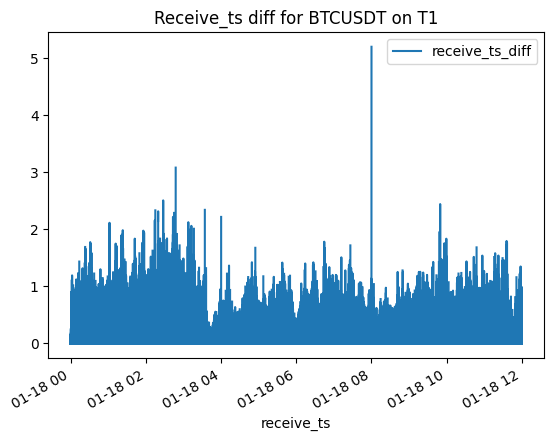

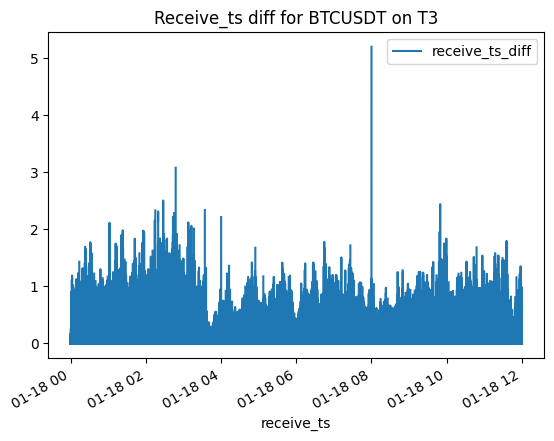

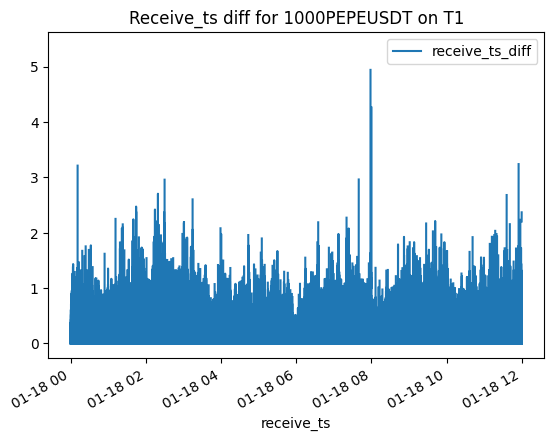

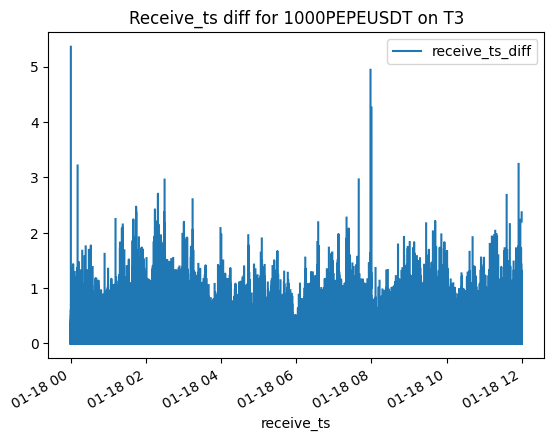

In [142]:
# Построим график receive_ts diff для данных
for security in SECURITIES:
    for server in SERVERS:
        trade_data[security][server].plot(x="receive_ts", y="receive_ts_diff", title=f"Receive_ts diff for {security} on {server}")
        plt.show()

In [143]:
# Посчитаем количество значений, которые больше 0.1 и 0.5 и 1 и выведем в таблицу

for security in SECURITIES:
    for server in SERVERS:
        print(f"Security: {security}, Server: {server}")
        print(f"Count > 0.01: {trade_data[security][server]['receive_ts_diff'][trade_data[security][server]['receive_ts_diff'] > 0.01].count()}")
        print(f"Count > 0.1: {trade_data[security][server]['receive_ts_diff'][trade_data[security][server]['receive_ts_diff'] > 0.1].count()}")
        print(f"Count > 0.5: {trade_data[security][server]['receive_ts_diff'][trade_data[security][server]['receive_ts_diff'] > 0.5].count()}")
        print(f"Count > 1: {trade_data[security][server]['receive_ts_diff'][trade_data[security][server]['receive_ts_diff'] > 1].count()}")

Security: BTCUSDT, Server: T1
Count > 0.01: 362703
Count > 0.1: 134352
Count > 0.5: 10046
Count > 1: 840
Security: BTCUSDT, Server: T3
Count > 0.01: 361183
Count > 0.1: 134204
Count > 0.5: 10042
Count > 1: 835
Security: 1000PEPEUSDT, Server: T1
Count > 0.01: 320110
Count > 0.1: 125272
Count > 0.5: 13581
Count > 1: 1578
Security: 1000PEPEUSDT, Server: T3
Count > 0.01: 318266
Count > 0.1: 125086
Count > 0.5: 13579
Count > 1: 1580


In [144]:
# Посчитаем количество значений, аггрегируем их используя count_values и выведем в таблицу и сохраним в csv

for security in SECURITIES:
    for server in SERVERS:
        data = trade_data[security][server]['receive_ts_diff'].value_counts().sort_index()
        print("Топ 10 частот для %s на %s" % (security, server))
        print(data.sort_values(ascending=False).head(10))
        print("Хвост 10 частот для %s на %s" % (security, server))
        print(data.tail(10))
        # Проанализируем данные
        print("---")
        data.to_csv(f"data/output/{security}_{server}.csv")

Топ 10 частот для BTCUSDT на T1
receive_ts_diff
0.00600    9393
0.01200    5883
0.01800    4600
0.02400    3843
0.03000    3259
0.03600    2843
0.04200    2554
0.04800    2237
0.05400    2110
0.00901    2002
Name: count, dtype: int64
Хвост 10 частот для BTCUSDT на T1
receive_ts_diff
2.21908    1
2.28900    1
2.31700    1
2.33378    1
2.33410    1
2.34297    1
2.44392    1
2.50887    1
3.08321    1
5.20185    1
Name: count, dtype: int64
---
Топ 10 частот для BTCUSDT на T3
receive_ts_diff
0.00100    1221
0.00108    1177
0.00103    1157
0.00106    1147
0.00098    1065
0.00096    1036
0.00102    1031
0.00110    1016
0.00112    1015
0.00107    1015
Name: count, dtype: int64
Хвост 10 частот для BTCUSDT на T3
receive_ts_diff
2.22173    1
2.28862    1
2.31612    1
2.33387    1
2.33482    1
2.34147    1
2.44370    1
2.50764    1
3.08363    1
5.20418    1
Name: count, dtype: int64
---
Топ 10 частот для 1000PEPEUSDT на T1
receive_ts_diff
0.00600    12830
0.01200     5630
0.01800     4069
0.02400 

In [145]:
# Посчитаем количество значений, аггрегируем их используя count_values и выведем в таблицу и сохраним в csv, проанализируем их. Максимальное минимальное и среднее значение
for security in SECURITIES:
    for server in SERVERS:
        data = trade_data[security][server]['receive_ts_diff'].round(3).value_counts().sort_index()
        print("Топ 10 частот для %s на %s" % (security, server))
        print(data.sort_values(ascending=False).head(10))
        print("Хвост 10 частот для %s на %s" % (security, server))
        print(data.tail(10))
        # Проанализируем данные
        print("---")
        data.to_csv(f"data/output/{security}_{server}_1ms.csv")




Топ 10 частот для BTCUSDT на T1
receive_ts_diff
0.001    26766
0.006    17645
0.004    13702
0.003    12427
0.002    11126
0.012    10905
0.005    10640
0.018     8806
0.009     7746
0.024     7469
Name: count, dtype: int64
Хвост 10 частот для BTCUSDT на T1
receive_ts_diff
2.160    1
2.219    2
2.289    1
2.317    1
2.334    2
2.343    1
2.444    1
2.509    1
3.083    1
5.202    1
Name: count, dtype: int64
---
Топ 10 частот для BTCUSDT на T3
receive_ts_diff
0.001    47931
0.002    22696
0.003    14588
0.004    11945
0.005     9640
0.006     8924
0.007     7779
0.008     7415
0.009     6841
0.010     6391
Name: count, dtype: int64
Хвост 10 частот для BTCUSDT на T3
receive_ts_diff
2.222    1
2.289    1
2.316    1
2.334    1
2.335    1
2.341    1
2.444    1
2.508    1
3.084    1
5.204    1
Name: count, dtype: int64
---
Топ 10 частот для 1000PEPEUSDT на T1
receive_ts_diff
0.001    45958
0.004    24493
0.006    24356
0.002    21519
0.003    20575
0.005    17832
0.012    10774
0.000    10376

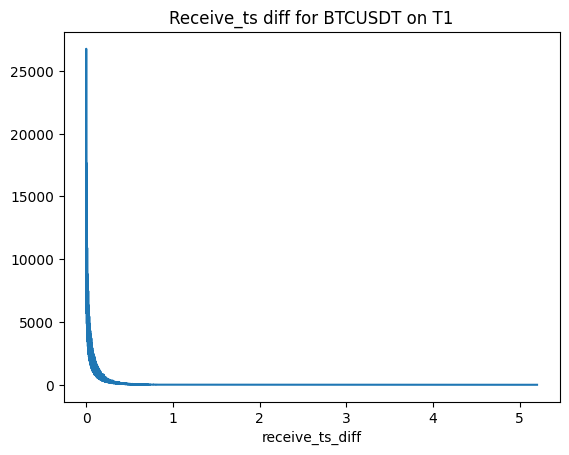

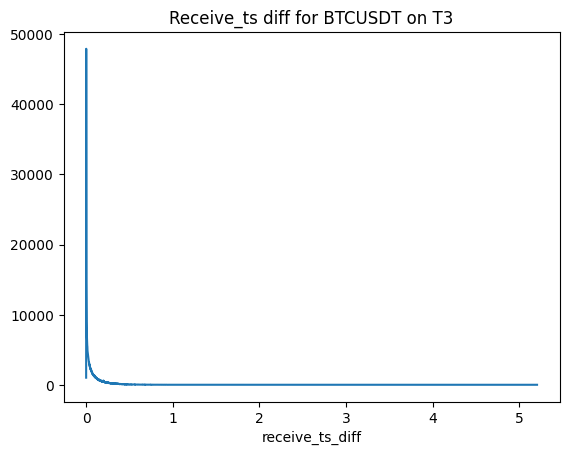

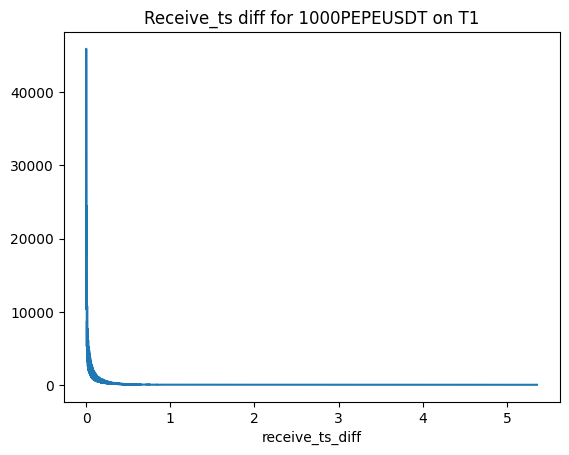

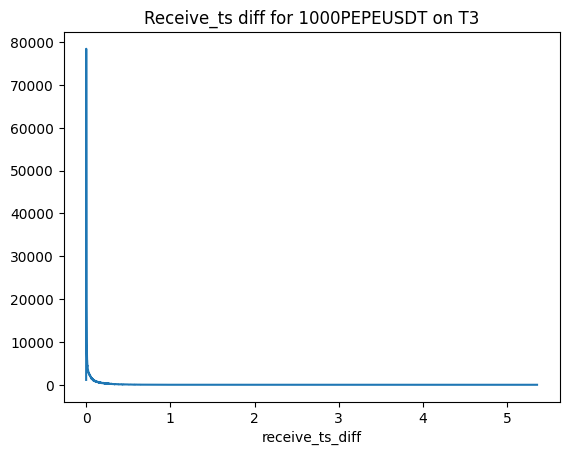

In [146]:
# Посчитаем количество значений, посчитаем частоты и отобразим их на графике
for security in SECURITIES:
    for server in SERVERS:
        data = trade_data[security][server]['receive_ts_diff'].round(3).value_counts().sort_index()
        data.plot(title=f"Receive_ts diff for {security} on {server}")
        plt.show()

In [147]:
# Выведем максимальные средние и минимальные значения по серверам
for security in SECURITIES:
    for server in SERVERS:
        print(f"Security: {security}, Server: {server}")
        print(f"Max: {trade_data[security][server]['receive_ts_diff'].max()}")
        print(f"Mean: {trade_data[security][server]['receive_ts_diff'].mean().round(7)}")
        print(f"Min: {trade_data[security][server]['receive_ts_diff'].min().round(7):.5f}")
        print()

Security: BTCUSDT, Server: T1
Max: 5.20185
Mean: 0.0896787
Min: 0.00001

Security: BTCUSDT, Server: T3
Max: 5.20418
Mean: 0.0858726
Min: 0.00005

Security: 1000PEPEUSDT, Server: T1
Max: 5.358
Mean: 0.084879
Min: 0.00001

Security: 1000PEPEUSDT, Server: T3
Max: 5.35619
Mean: 0.079237
Min: 0.00004



## Выводы

- Средние значения `receive_ts_diff` для всех данных на сервере `T1` выше, чем на сервере `T3`.
- Максимальные значения `receive_ts_diff` для всех данных на сервере `T1` выше, чем на сервере `T3`.
- Минимальные значения `receive_ts_diff` для всех данных на сервере `T1` ниже, чем на сервере `T3`.
